# SURP Project - Mukesh Taank (mtaank)

## Supervisors: P.G. Martin and A. Marchal

### CTA 200H - May 2020

This is a python notebook that will discuss the process of collecting and analyzing a data cube for the designated SPIDER region. This project is meant to give me an introduction to ROHSA and how it works. Also, this project will help me to understand how to handle archival HI spectral data stored in data cubes, extract spectra, and manipulate the spectra (integrals, moments, etc.).
________________________________________________________________________________________________________________________

## Download the Cube Data

The first thing I need to do is download the data cube. I went to the address: https://www.cita.utoronto.ca/GHIGLS/ to download the data cube. The designated region I have been told to focus on is the SPIDER region. 

In [1]:
!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

--2020-05-19 12:54:42--  https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits
Resolving www.cita.utoronto.ca... 128.100.76.44
Connecting to www.cita.utoronto.ca|128.100.76.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84513600 (81M) [image/fits]
Saving to: “GHIGLS_SPIDER_Tb.fits.19”

100%[======================================>] 84,513,600  96.8M/s   in 0.8s    

2020-05-19 12:54:44 (96.8 MB/s) - “GHIGLS_SPIDER_Tb.fits.19” saved [84513600/84513600]



Here, ROHSA can also be installed since it will be used it later on.

In [2]:
!pip install ROHSApy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/python/3.7.3/bin/python3.7 -m pip install --upgrade pip' command.


## Load the Cube to Produce a Spectrum

Now, the data cube needs to be loaded to be analyzed. One spectrum (cross-section) of the cube is desired that has two distinct peaks to represent the low and intermediate velocity gas.

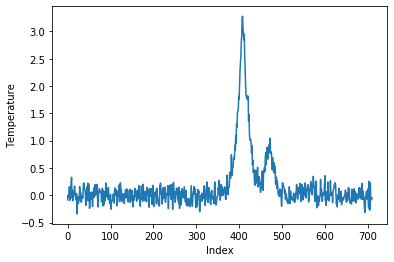

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA

# Now I need to load the data cube that I collected in the above step.
fitsname = "GHIGLS_SPIDER_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[0][:,:,:]
# In the PPV cube, there are 3 axes (Representing the three spaces in the list).
# The first is the velocity axis. The others represent the position coordinates, x and y.

# One region that will provide the peaks that I need is with x = 65, y = 154.
spectrum = cube[:,154,65]

f1 = plt.figure()
plt.plot(spectrum)
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.show()
f1.savefig("f1_spectrum_index.pdf", bbox_inches='tight')

When I ran this code and produced a spectrum, the large peak occurred at ~400. I need this to be at zero to agree with the reference from the header. So I need a function that adjusts this spectrum and makes the units of km/s make sense.

In [4]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))]
    # Puts in units of km/s
    
    return vel

Now I can modify the spectrum by using the function 'spec2velocity()' to get the velocity axis.

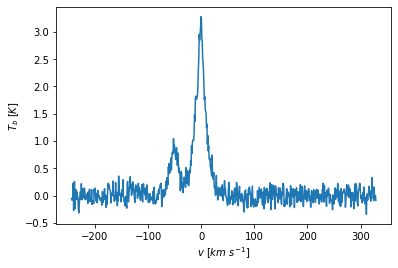

In [5]:
index_arr = np.arange(cube.shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

f2 = plt.figure()
plt.plot(vel, spectrum)
plt.xlabel("$v$ [$km$ $s^{-1}$]")
plt.ylabel("$T_{b}$ [$K$]")
plt.show()
f2.savefig("f2_spectrum_velocity.pdf", bbox_inches='tight')

One thing that I notice in the spectrum is that on the left side (around -150) there looks to be another peak, which could represent the presence of an HVC. The reason I think this is because the data does not flutuate about zero at this point, it goes up in a wide "gaussian shape", then turns back into the noise.

## Getting the Spectrum using ROHSA

Since I have already installed ROHSApy and also imported it, I can call on the ROHSA function to plot the spectrum directly. It will already adjust for the velocity in $km$ $s^{-1}$. This step is just to show the usefulness of using ROHSA for the spectrum generation.

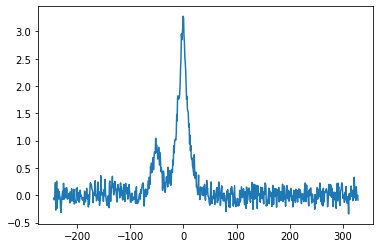

In [6]:
core = ROHSA(cube,hdr=hdr)

plt.plot(core.v, spectrum)
plt.show()

## Computing the Velocity Moments

##### The first velocity moment (moment zero) gives us information about the column density.

In [7]:
C = 1.82243e18 # A constant for unit conversion. C has units of cm^-2 (K km s^-1)^-1

# Need to define dv for the integral (which is just the channel spacing)
dv = abs(cdelt3)

NHI_mom0 = np.sum(spectrum)*dv*C # This has units of HI column density (atoms/cm^2)
print("The Column Density is:", NHI_mom0, "atoms/cm^2")

The Column Density is: 1.6483689662639895e+20 atoms/cm^2


##### The second velocity moment (moment 1) tells us the is the centroid velocity

In [8]:
VelCent_mom1 = (np.sum(spectrum*vel)*dv*C)/NHI_mom0
print("The Centroid Velocity is:",VelCent_mom1, "km/s")

The Centroid Velocity is: -11.610893516573958 km/s


##### The third moment (moment 2) gives the Dispersion of the spectrum

In [9]:
Disp_mom2 = np.sqrt(np.sum((vel**2)*spectrum) / np.sum(spectrum) - VelCent_mom1**2)
print("The Dispersion is:",Disp_mom2, "km/s")

The Dispersion is: 26.546720307774557 km/s


### Now we can show the maps of these moments over the whole cube

For the column density map, we want to sum the cube over the velocity axis 

Here is a map of the Integrated Column Density


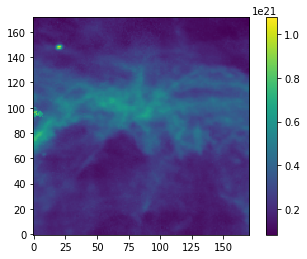

In [53]:
NHI_map = np.sum(cube, axis=0)*dv*C

f3 = plt.figure()
print("Here is a map of the Integrated Column Density")
plt.imshow(NHI_map, origin="lower")
plt.colorbar()
f3.savefig("f3_NHI_columndensity_map.pdf", bbox_inches='tight')

What we see is the SPIDER picture. This is great because it is what we were hoping to see with this first moment. This map tells us the column density in units of HI column density.

For the Velocity Centroid map, we still want to sum oover the velocity axis, but now we are trying to multiply a 3D cube with a 1D array. So, we can use the tensordot() function in NumPy to do this.

Here we see the Centroid Velocity map


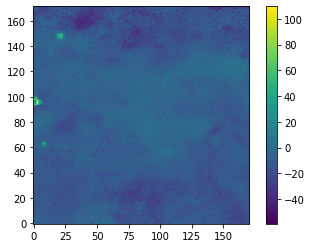

In [11]:
Vel_Cent_map = np.tensordot(core.v, cube, axes=(0,0)) / np.sum(cube, axis=0)

f4 = plt.figure()
print("Here we see the Centroid Velocity map")
plt.imshow(Vel_Cent_map, origin="lower")
plt.colorbar()
f4.savefig("f4_centroidvelocity_map.pdf", bbox_inches='tight')

Here is the map of the dispersion


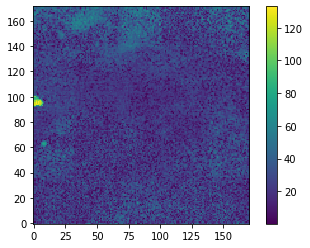

In [12]:
Disp_map2 = np.tensordot(np.array(core.v)**2, cube, axes=(0,0)) / np.sum(cube, axis=0) - Vel_Cent_map**2
Disp_map = np.sqrt(abs(Disp_map2))

f5 = plt.figure()
print("Here is the map of the dispersion")
plt.imshow(Disp_map, origin="lower")
plt.colorbar()
f5.savefig("f5_dispersion_map.pdf", bbox_inches='tight')

### Similarly, we can zoom in on the peaks of the spectrum and recompute the moments

#### These are the calculations for the moments of peak 1 (largest peak - LVC)

The maximum of the spectrum is: 3.279303 and occurs at index  408


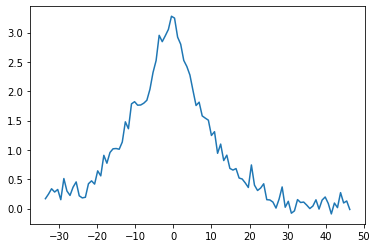

In [13]:
# This section revolves around the main peak
maxval = np.max(spectrum)
index_max = np.argmax(spectrum)
print("The maximum of the spectrum is:", maxval, "and occurs at index ", index_max)

spectrum_peak1 = cube[350:450,154,65]
vel_peak1 = vel[350:450]

plt.plot(vel_peak1, spectrum_peak1)
plt.show()

In [14]:
# Moment 0
NHI_mom0_peak1 = np.sum(spectrum_peak1)*dv*C # This has units of HI column density (atoms/cm^2)
print("The Column Density is:", NHI_mom0_peak1, "atoms/cm^2")

The Column Density is: 1.327277201695443e+20 atoms/cm^2


Here is a map of the Column Density for the LVC over the region


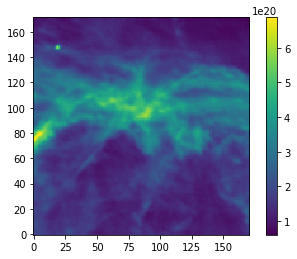

In [15]:
NHI_map_peak1 = np.sum(cube[350:450], 0)* dv * C

plt.figure()
plt.imshow(NHI_map_peak1, origin="lower")
print("Here is a map of the Column Density for the LVC over the region")
plt.colorbar()

Now that we are focusing on the LVC, we see a very dense center of the SPIDER, full of Hydrogen atoms. As we go away from the center into the legs of the SPIDER, it is less dense. There is a small section in the left-most middle area that is just as, or even more dense than the center of the SPIDER.

In [16]:
# Moment 1
VelCent_mom1_peak1 = (np.sum(spectrum_peak1*vel_peak1)*dv*C)/NHI_mom0_peak1
print("The Centroid Velocity is:",VelCent_mom1_peak1,"km/s")

The Centroid Velocity is: -0.9781245055027454 km/s


In [17]:
# Moment 2
Disp_mom2_peak1 = np.sqrt(np.sum((vel_peak1**2)*spectrum_peak1) / np.sum(spectrum_peak1) \
                 - VelCent_mom1_peak1**2)
print("The Dispersion is:",Disp_mom2_peak1, "km/s")

The Dispersion is: 12.59737880742432 km/s


#### We can now do the same for peak 2 (lower peak - IVC).

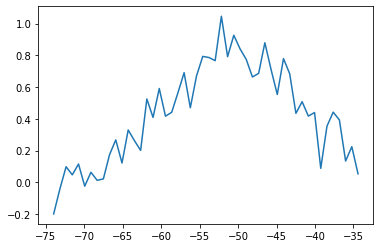

In [18]:
# This section revolves around the smaller peak

spectrum_peak2 = cube[450:500,154,65]
vel_peak2 = vel[450:500]

plt.plot(vel_peak2, spectrum_peak2)
plt.show()

In [19]:
# Moment 0
NHI_mom0_peak2 = np.sum(spectrum_peak2)*dv*C # This has units of HI column density (atoms/cm^2)
print("The Column Density is:", NHI_mom0_peak2, "atoms/cm^2")

The Column Density is: 3.1464537180423926e+19 atoms/cm^2


Here is a map of the Column Density for the IVC over the region


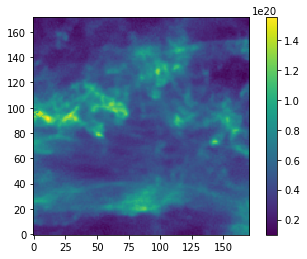

In [20]:
NHI_map_peak2 = np.sum(cube[450:500], 0)* dv * C

plt.figure()
plt.imshow(NHI_map_peak2, origin="lower")
print("Here is a map of the Column Density for the IVC over the region")
plt.colorbar()

One big difference we see with this map focusing on the IVC, compared to the LVC, is the image of the SPIDER is not there. In this map, it just looks like a large cloud. Also, in this region, it appears to be less dense by almost a factor 10.

In [21]:
# Moment 1
VelCent_mom1_peak2 = (np.sum(spectrum_peak2*vel_peak2)*dv*C)/NHI_mom0_peak2
print("The Centroid Velocity is:",VelCent_mom1_peak2, "km/s")

The Centroid Velocity is: -50.67502256345447 km/s


In [22]:
# Moment 2
Disp_mom2_peak2 = np.sqrt(np.sum((vel_peak2**2)*spectrum_peak2) / np.sum(spectrum_peak2) \
                 - VelCent_mom1_peak2**2)
print("The Dispersion is:",Disp_mom2_peak2, "km/s")

The Dispersion is: 7.538770859538204 km/s


## Measuring the Noise of the "End Channels"

We can see that on either end of the spectrum, there is a lot of noise and is fluctuating around ~0. We can take a few channels from each end of the spectrum and find the noise by computing the standard deviation of that set of data. Since the channel length is about 0.8 km/s, we can take about 30 channels on each side (so a slice of length 24) and use this.

In [23]:
end_channel_left = cube[:24,154,65] # Take a slice of the left-most part of spectrum
print("The noise on the left end channel is given by: ", np.std(end_channel_left))

The noise on the left end channel is given by:  0.12879677


In [24]:
end_channel_right = cube[-24:,154,65] # Take a slice of the right-most part of spectrum
print("The noise on the right end channel is given by: ", np.std(end_channel_right))

The noise on the right end channel is given by:  0.1476112


We can produce a map of the noise at the end channels over the whole cube as well

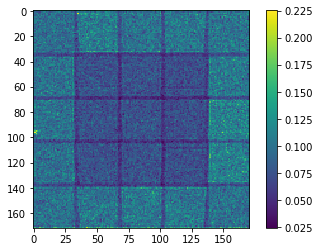

In [25]:
noise_cube = cube[:24]
noise_map = np.std(noise_cube, 0)

f6 = plt.figure()
plt.imshow(noise_map)
plt.colorbar()
f6.savefig("f6_noise_map.pdf", bbox_inches='tight')

From this map of the noise in the cube, we see a very organized square shape pattern. The noise is much more dense around the outer-most part of the square, and less dense towards the inner part. This has to do with the scanning of the telescope to gather data. The inner part has less noise because it was observed twice, rather than once, so it will have less errors.

## Fitting the Data

Now that we have a spectrum, we want to be able to represent this set of data by a nice curve, or function, to be able to understand the relationship of what is observed. ROHSA is special in that it fits multiple gaussian functions to the data set as they provide very important information about the spectrum. We can try to fit gaussians to the data to be able to represent it more nicely.

In [26]:
from scipy.optimize import curve_fit

### Fitting a single Gaussian Function 

First, we can try to fit the spectrum using only one gaussian function. I would expect the gaussian to center at the main peak (around zero). Obviously, this will not be very accurate for the spectrum since it has two peaks. Later on, we can fit multiple gaussian functions.

In [27]:
# We are trying to fit a Gaussian functions, so let's define a function to create a gaussian
def one_gauss_func(x, amp, cent, sigma):
    '''
    Description: 
        Evaluates a Gaussian function given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        amp - The amplitude of the Gaussian - float
        cent - The location of the of the peak - float 
        sigma - The width of the peak - float
    
    Returns:
        The function evaluated at x - float
    '''
    return amp*np.exp(-(x-cent)**2/(2*sigma**2))

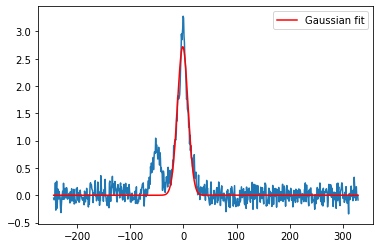

In [28]:
x_data_1gauss = index_arr
y_data_1gauss = spectrum

#Guesses for the parameters:
amp_1gauss = 3.
cent_1gauss = 400.
sigma_1gauss = 20.

p_opt_1gauss, p_cov_1gauss = curve_fit(one_gauss_func, x_data_1gauss, y_data_1gauss, p0 = [amp_1gauss, cent_1gauss, sigma_1gauss])
p_err = np.sqrt(np.diag(p_cov_1gauss))

amp_1gauss, cent_1gauss, sigma_1gauss = p_opt_1gauss

gauss = [one_gauss_func(x, amp_1gauss, cent_1gauss, sigma_1gauss) for x in x_data_1gauss]

f7 = plt.figure()
plt.plot(vel, spectrum)
plt.plot(vel, gauss, 'r-', label="Gaussian fit")
plt.legend()
plt.show()
f7.savefig("f7_1_gaussian_spectrum.pdf", bbox_inches='tight')

Now that we have a fitted Gaussian, we can check the chi square, $\chi^{2}$, value to see how well this is fit.

We can find the value of $\chi^{2}$ by using the formula:

$$ \chi^{2} = \sum\limits_{i} \frac{[N_{exp} - N]^{2}}{\sigma^{2}} $$

where $N_{exp}$ is the experimental data (the actual spectrum) and $N$ is the model fitted to the data. $\sigma$ is the standard deviation of the data.
For a good fit, the value of $\chi^{2}$ will be as close to the value of # of Points - # of Parameters, as possible, which in this case is about 700.

In [29]:
stdev_1gauss = np.std(spectrum[5:25])
print("Std:", stdev_1gauss)

Std: 0.13532586


In [30]:
N_1gauss = spectrum # Actual data
N_exp_1gauss = gauss # Gaussian model 

r_1gauss = N_1gauss - N_exp_1gauss

chisq_1gauss = np.sum((r_1gauss/stdev_1gauss)**2)
print("The value of chi squared is:", chisq_1gauss)

The value of chi squared is: 1408.5074568561436


Trying to fit only one Gaussian to this set of data works very well in fitting one of the peaks, however, the second peak is basically ignored. From the value of $\chi^{2}$, which is about 1400, we know that the fit is not all that great since it is so large. It should be as close to the value of # of Points - # of Parameters, which is about 700. The noise plays a big part in the error.

### Fitting multiple Gaussian Functions 

In [31]:
# We are trying to fit multiple Gaussian functions, so we define a function to create a combination of gaussians
def two_gauss_func(x, amp1, cent1, sigma1, amp2, cent2, sigma2):
    '''
    Description: 
        Evaluates the combination of 2 Gaussian functions given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        amp1 - The amplitude of the Gaussian number 1- float
        cent1 - The location of the of Gaussian 1 - float 
        sigma1 - The width of Gaussian 1 - float
        amp2 - The amplitude of the Gaussian number 2- float
        cent2 - The location of the of Gaussian 2 - float
        sigma2 - The width of Gaussian 2 - float        
        
    Returns:
        The function evaluated at x - float
    '''
    return amp1*np.exp(-(x-cent1)**2/(2*sigma1**2)) + amp2*np.exp(-(x-cent2)**2/(2*sigma2**2))

In [32]:
x_data_2gauss = index_arr
y_data_2gauss = spectrum

# Initial Guesses for the parameters:
amp1_2gauss, cent1_2gauss, sigma1_2gauss = 3., 400, 20.
amp2_2gauss, cent2_2gauss, sigma2_2gauss = 1., 475, 30.

p_opt_2gauss, p_cov_2gauss = curve_fit(two_gauss_func, x_data_2gauss, y_data_2gauss, p0=[amp1_2gauss, cent1_2gauss,\
                                       sigma1_2gauss, amp2_2gauss, cent2_2gauss, sigma2_2gauss])


amp1_2gauss, cent1_2gauss, sigma1_2gauss = p_opt_2gauss[0:3]
amp2_2gauss, cent2_2gauss, sigma2_2gauss = p_opt_2gauss[3:6]

# Peak 1 (gauss1) is the largest peak (LVC). Peak 2 (gauss2) is the smaller peak (IVC)
gauss1_2gauss = one_gauss_func(x_data_2gauss, amp1_2gauss, cent1_2gauss, sigma1_2gauss)
gauss2_2gauss = one_gauss_func(x_data_2gauss, amp2_2gauss, cent2_2gauss, sigma2_2gauss)

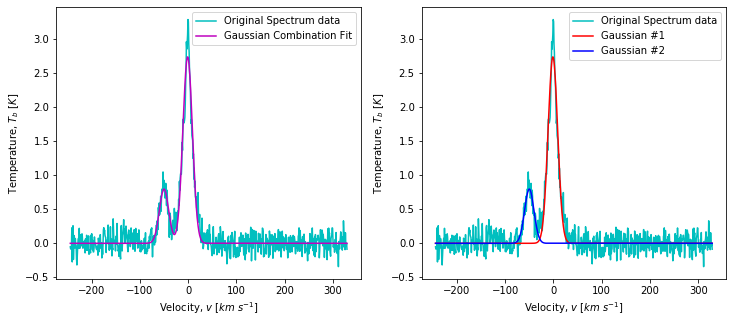

In [33]:
# We can now plot the fitted function
gauss_comb_2gauss = [two_gauss_func(x,amp1_2gauss,cent1_2gauss,sigma1_2gauss,amp2_2gauss,cent2_2gauss,sigma2_2gauss)\
                     for x in x_data_2gauss]

# Now we can plot the functions along with the spectrum
f8 = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(vel, spectrum,'c-', label="Original Spectrum data")
plt.plot(vel, gauss_comb_2gauss, 'm-', label="Gaussian Combination Fit")
plt.xlabel("Velocity, $v$ [$km$ $s^{-1}$]")
plt.ylabel("Temperature, $T_{b}$ [$K$]")
plt.legend(loc='best')

# We can also plot the 2 gaussians separately
plt.subplot(1,2,2)
plt.plot(vel, spectrum, 'c-', label="Original Spectrum data")
plt.plot(vel, gauss1_2gauss, 'r-', label="Gaussian #1")
plt.plot(vel, gauss2_2gauss, 'b-', label="Gaussian #2")
plt.xlabel("Velocity, $v$ [$km$ $s^{-1}$]")
plt.ylabel("Temperature, $T_{b}$ [$K$]")
plt.legend(loc='best')

plt.show()
f8.savefig("f8_2_gaussian_spectrum.pdf",bbox_inches='tight')

We can see that adding a second Gaussian function to the fitting of the spectrum makes it a much more accurate fit. We see the Gaussian peaks for both the spectrum peaks, which is what we wanted.

In [34]:
stdev_2gauss = np.std(spectrum[5:25])
print("Std:", stdev_2gauss)

Std: 0.13532586


In [35]:
N_2gauss = gauss_comb_2gauss # Actual data
N_exp_2gauss = spectrum # Gaussian model 

r_2gauss = N_2gauss - N_exp_2gauss

chisq_2gauss = np.sum((r_2gauss/stdev_2gauss)**2)
print("The value of chi squared is:", chisq_2gauss)

The value of chi squared is: 675.518974721212


Now that we are fitting two gaussians compared to only one, the fit is much better. The other peak is properly accounted for. The value of $\chi^{2}$ is closer to the value of # of Points - Number of Parameters (which is about 700), meaning that the 2 gaussian model is a much better approximation. There is still error in the fit and this can come from all the noise away from the peaks,that is why the $\chi^{2}$ is not exactly 700. 

##### Finding the Residual Spectrum 

We can also now plot the residual spectrum (data - model) to see how accurate the fit was.

The standard deviation of the residual is: 0.1317873516284428


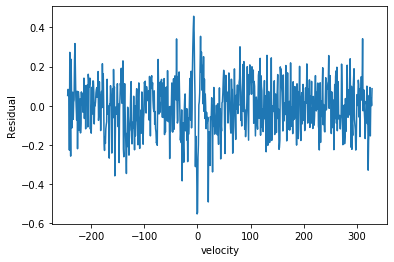

In [36]:
# Residual Spectrum (data-model)
model_spec_2gauss = gauss_comb_2gauss
data_spec_2gauss = spectrum
residual_spec_2gauss = model_spec_2gauss - data_spec_2gauss

print("The standard deviation of the residual is:", np.std(residual_spec_2gauss))

plt.plot(vel,residual_spec_2gauss)
plt.xlabel('velocity')
plt.ylabel('Residual')
plt.show()

From this residual spectrum, we can see that the data model is fairly accurate. The standard deviation of the residual spectrum is only about 0.13. Ideally, the residual would be zero, but the accuracy of the gaussian model produced a very good appoximation because the deviation is relatively low.

##### Finding the Full Width Half Maximum (FWHM)

Now that we have found and fitted Gaussian functions to the spectrum, we can evaluate the full width half maximum (FWHM) to get some information about the velocity of the LVC and the IVC.

We can show how to find the FWHM by using the equation of the Gaussian function:
$$ f(x) = Ae^{-x^{2} / 2\sigma^{2}} $$
Note: the value of the full width half maximum is independent of the position of the center.
At half of the maximum, let x = h. We know that at the FWHM, the value of f(h) will be 0.5A (half the amplitude):
$$ 0.5 A = Ae^{-h^{2} / 2\sigma^{2}} $$
We can cancel the amplitudes and take the natural logarithm of both sides:
$$ ln(0.5) = -h^{2} / 2\sigma^{2} $$
Now we can just isolate for h.
$$ h^{2} = -2ln(0.5)\sigma^{2} $$
$$ h^{2} = 2ln(2)\sigma^{2} $$
$$ h = \sqrt{2ln(2)}\sigma $$
Now that we have h, we know that the full width is 2h, so we can multiply by 2 to get the FWHM (call this $\Gamma$):
$$ \Gamma = 2\sqrt{2ln(2)}\sigma $$
$$ \Gamma \approx 2.355\sigma $$

Now that we have generated the scheme for finding the FWHM, we can implement this into the code using the optimal sigma parameters that were calculated above.

In [37]:
# We have the two Gaussians, so we can find FWHM for both

sigma1_2gauss = sigma1_2gauss # From peak 1 (LVC)
sigma2_2gauss = sigma2_2gauss # From peak 2 (IVC)

FWHM_peak1_2gauss = 2*np.sqrt(2*np.log(2))*sigma1_2gauss
print("The FWHM of peak 1 (LVC) is:", FWHM_peak1_2gauss, "km/s")

FWHM_peak2_2gauss = 2*np.sqrt(2*np.log(2))*sigma2_2gauss
print("The FWHM of peak 2 (IVC) is:", FWHM_peak2_2gauss, "km/s")

The FWHM of peak 1 (LVC) is: 28.9358926644951 km/s
The FWHM of peak 2 (IVC) is: 28.247953030216568 km/s


So from the FWHM data of each peak, we see that they are very close. The peak widths are almost equal. However, peak 1 is wider than peak 2.

Now that we have the FWHM data, we can use it to convert the width into a temperature value using the relationship coming from the kinetic theory of gases:
$$ (1/2) m v^{2} = (f/2) k_{B} T $$
where f is the degrees of freedom. In this problem, we are dealing with non-vibrating hydorgen atoms, and only looking at the z-axis, so we can set $f$=1. Now we can simplify the expression and isolate for v, which we are taking to be the FWHM (we defined this to be represented by $\Gamma$). Doing this, we get:

$$ \Gamma = \sqrt{k_B T / m_H} $$

So using this formula, and the calculated FWHM, I can express the FWHM in units of temperature (Kelvin).

In [38]:
m_H = 1.6735575e-27 # Mass of a hydrogen atom in units of kg
k_B = 1.3806485e-23 # Boltzmann constant in units of m^2 kg s^-2 K^-1

FWHM_peak1_2gauss_ms = FWHM_peak1_2gauss*1000. # This puts it in units of m/s rather than km/s
FWHM_peak2_2gauss_ms = FWHM_peak2_2gauss*1000. # This puts it in units of m/s rather than km/s

FWHM_peak1_2gauss_temp = ((FWHM_peak1_2gauss_ms**2)*m_H) / k_B
print("The FWHM for the LVC expressed in units of temperature is:",FWHM_peak1_2gauss_temp, "K")
FWHM_peak2_2gauss_temp = ((FWHM_peak2_2gauss_ms**2)*m_H) / k_B
print("The FWHM for the IVC expressed in units of temperature is:",FWHM_peak2_2gauss_temp, "K")

The FWHM for the LVC expressed in units of temperature is: 101491.87655653403 K
The FWHM for the IVC expressed in units of temperature is: 96723.38296704883 K


Now we see the values of the FWHM from km/s into Kelvin. This helps give an idea on how hot the cloud is.

## Now that we have looked at a Single Spectrum, we can take a Face of the Cube and Generate an Average Spectrum

We have been dealing with one single spectrum, which is just one pixel on the cube. Now we want to look at a face of the cube ($m$ by $m$ pixels) and generate $m^{2}$ spectra. Then I can take the average of all these spectra and compare the single spectrum I have been working with above. We want to stay around the x=65 and y=154 area, so we will go +/- 10 on either side of the x and y value. So the x range will be 55 < x < 75 and the y range will be 144 < y < 164.

#### Generating the Average Spectrum

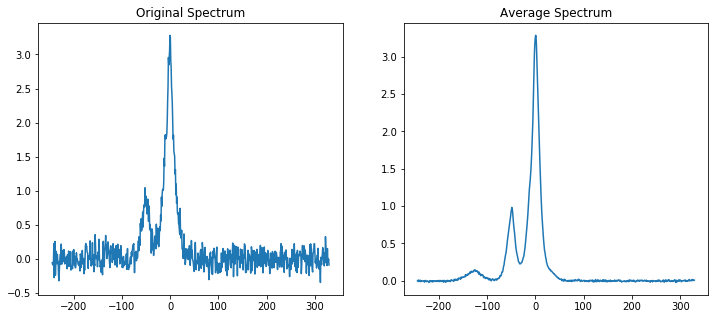

In [39]:
# We want to take a face of the cube about 20x20 pixels (still want the full velocity axis)

subcube = cube[:,144:164,55:75] # Still in the same region of the original x=65 and y=154
avg_subcube = np.mean(subcube, (1,2))

f9 = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Original Spectrum")
plt.plot(vel, spectrum)

plt.subplot(1, 2, 2)
plt.title("Average Spectrum")
plt.plot(vel, avg_subcube)

plt.show()
f9.savefig("f9_origial_vs_average_spec.pdf", bbox_inches='tight')

Now that we have the average spectrum, we can directly compare it to the single spectrum. The first thing is that there is very little noise throughout. We can still easily identify the LVC and IVC from the peaks, however, now that the noise has been minimized, there is a distinct peak appearing at about -120 km/s. This can represent the presence of an HVC (High velocity cloud). In the first spectrum, we observed that there could possibly be an HVC there, but the noise was so strong that it was very difficult. Here, it is very clear that this is not just noise, but a distinct peak.

#### Fitting the Average Spectrum with Multiple Gaussian Functions

Now we can use the gaussian fitting functions above to fit some gaussian curves to this average spectrum. In this case, it will be easier to plot a third gaussian where the HVC is, compared to the original spectrum where the noise makes it difficult. So we can add a third gaussian to our function to account for this.

In [40]:
def multi_gauss_func(x, amp1, cent1, sigma1, amp2, cent2, sigma2, amp3, cent3, sigma3):
    return amp1*np.exp(-(x-cent1)**2/(2*sigma1**2)) + amp2*np.exp(-(x-cent2)**2/(2*sigma2**2))\
           + amp3*np.exp(-(x-cent3)**2/(2*sigma3**2))

In [41]:
x_data_avg = index_arr
y_data_avg = avg_subcube

# Initial Guesses for the parameters:
amp1_avg, cent1_avg, sigma1_avg = 3., 400, 20.
amp2_avg, cent2_avg, sigma2_avg = 1., 475, 30.
amp3_avg, cent3_avg, sigma3_avg = 0., 600, 60.

p_opt_avg, p_cov_avg = curve_fit(multi_gauss_func, x_data_avg, y_data_avg, p0=[amp1_avg,cent1_avg,sigma1_avg,\
                                 amp2_avg,cent2_avg,sigma2_avg,amp3_avg,cent3_avg,sigma3_avg])

amp1_avg, cent1_avg, sigma1_avg = p_opt_avg[0:3]
amp2_avg, cent2_avg, sigma2_avg = p_opt_avg[3:6]
amp3_avg, cent3_avg, sigma3_avg = p_opt_avg[6:9]

# Peak 1 (gauss1) is the largest peak (LVC). Peak 2 (gauss2) is the smaller peak (IVC)
gauss1_avg = one_gauss_func(x_data_avg, amp1_avg, cent1_avg, sigma1_avg)
gauss2_avg = one_gauss_func(x_data_avg, amp2_avg, cent2_avg, sigma2_avg)
gauss3_avg = one_gauss_func(x_data_avg, amp3_avg, cent3_avg, sigma3_avg)

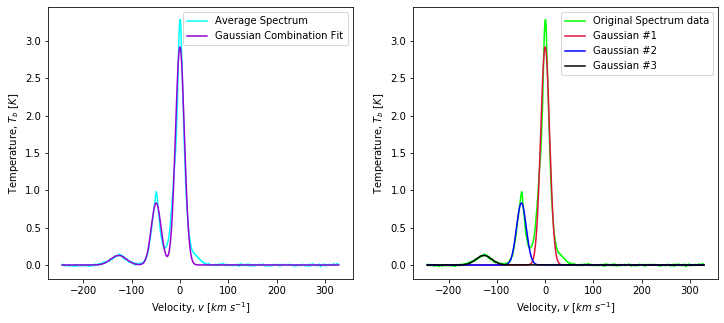

In [42]:
# We can plot the fitted function
gauss_comb_avg = [multi_gauss_func(x,amp1_avg,cent1_avg,sigma1_avg,amp2_avg,cent2_avg,sigma2_avg\
                  ,amp3_avg,cent3_avg,sigma3_avg) for x in x_data_avg]

# Now we can plot the functions along with the spectrum
f10 = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(vel, avg_subcube, color='cyan', label="Average Spectrum")
plt.plot(vel, gauss_comb_avg,color='darkviolet', label="Gaussian Combination Fit")
plt.xlabel("Velocity, $v$ [$km$ $s^{-1}$]")
plt.ylabel("Temperature, $T_{b}$ [$K$]")
plt.legend(loc='upper right')

# We can also plot the 2 gaussians separately
plt.subplot(1,2,2)
plt.plot(vel, avg_subcube, color='lime', label="Original Spectrum data")
plt.plot(vel, gauss1_avg, color='crimson', label="Gaussian #1")
plt.plot(vel, gauss2_avg, 'b-', label="Gaussian #2")
plt.plot(vel, gauss3_avg, 'k-', label="Gaussian #3")
plt.xlabel("Velocity, $v$ [$km$ $s^{-1}$]")
plt.ylabel("Temperature, $T_{b}$ [$K$]")
plt.legend(loc='best')

plt.show()
f10.savefig("f10_average_multigauss.pdf", bbox_inches='tight')

Similar to the other fits, we can calcualte the chi squared value to see how much better the gaussian fit is for the average spectrum.

We can find the standard deviation of the average spectrum end channel. In the above calculation of standard deviation, we got a value of 0.13. Now we are dealing with a average spectrum of 20x20 pixels (400 spectra). So we would expect the standard deviation to go down by a factor of sqrt(N) = sqrt(400) = 20. 

In [43]:
stdev_avg = np.std(avg_subcube[5:25]) 
print("Std:", stdev_avg)

stdev_spec = np.std(spectrum[5:25])

print("If we divide the standard deviation of the single spectrum by the average spectrum, it should be about 20.")
print("The ratio is:",stdev_spec / stdev_avg)

Std: 0.006471699
If we divide the standard deviation of the single spectrum by the average spectrum, it should be about 20.
The ratio is: 20.910408


Using this information, we can find the value of chi squared for the average spectrum

In [54]:
N_avg = avg_subcube # Actual spectrum data
N_exp_avg = gauss_comb_avg # Gaussian model 

r_avg = N_avg - N_exp_avg

chisq_avg = np.sum((r_avg/stdev_avg)**2)
print("The value of chi squared is:", chisq_avg)

The value of chi squared is: 76438.029551715


#### Calculating the FWHM of the Gaussians for the Average Spectrum

Now, we can use this new gaussian model for the average spectrum and find the FWHM of the peaks, using the relation derived above, to find some information about the clouds.

In [45]:
# We have the 3 Gaussians, so we can find FWHM for all

sigma1_avg = sigma1_avg # From peak 1 (LVC)
sigma2_avg = sigma2_avg # From peak 2 (IVC)
sigma3_avg = sigma3_avg # From peak 3 (HVC)

FWHM_peak1_avg = 2*np.sqrt(2*np.log(2))*sigma1_avg
print("The FWHM of peak 1 (LVC) is:", FWHM_peak1_avg, "km/s")

FWHM_peak2_avg = 2*np.sqrt(2*np.log(2))*sigma2_avg
print("The FWHM of peak 2 (IVC) is:", FWHM_peak2_avg, "km/s")

FWHM_peak3_avg = 2*np.sqrt(2*np.log(2))*sigma3_avg
print("The FWHM of peak 3 (HVC) is:", FWHM_peak3_avg, "km/s")

The FWHM of peak 1 (LVC) is: 26.903347286508335 km/s
The FWHM of peak 2 (IVC) is: 29.49375496016301 km/s
The FWHM of peak 3 (HVC) is: 47.36978118798654 km/s


Now we can convert these to have units of temperature.

In [46]:
FWHM_peak1_avg_ms = FWHM_peak1_avg*1000. # This puts it in units of m/s rather than km/s
FWHM_peak2_avg_ms = FWHM_peak2_avg*1000. # This puts it in units of m/s rather than km/s
FWHM_peak3_avg_ms = FWHM_peak3_avg*1000. # This puts it in units of m/s rather than km/s

FWHM_peak1_avg_temp = ((FWHM_peak1_avg_ms**2)*m_H) / k_B
print("The FWHM for the LVC expressed in units of temperature is:",FWHM_peak1_avg_temp, "K")

FWHM_peak2_avg_temp = ((FWHM_peak2_avg_ms**2)*m_H) / k_B
print("The FWHM for the IVC expressed in units of temperature is:",FWHM_peak2_avg_temp, "K")

FWHM_peak3_avg_temp = ((FWHM_peak3_avg_ms**2)*m_H) / k_B
print("The FWHM for the HVC expressed in units of temperature is:",FWHM_peak3_avg_temp, "K")

The FWHM for the LVC expressed in units of temperature is: 87734.44814365086 K
The FWHM for the IVC expressed in units of temperature is: 105442.97444877926 K
The FWHM for the HVC expressed in units of temperature is: 271994.5926994636 K


Compared to the single spectrum, the FWHM values are fairly similar. Using the average spectrum gave us the temperature of the IVC > LVC whereas the single spectrum gave us the temperature of the IVC < LVC. I think using average spectrum provides more accurate results because it takes into account a lot more data. One thing that is different with this is that we can find information about the HVC. The FWHM of the HVC (in Kelvin) is almost 3 times larger than the IVC.

#### Plotting maps for the Gaussian Parameters

Now that we have fit our gaussians to the average spectrum, we can look at a whole face of the cube. We have a square that is 20x20 pixels along x and y. Each of these pixels represents a spectrum. If we fit gaussians to each one of these spectra, we can use all gaussian parameters to generate column density maps over this small section of the cube. 

In [47]:
# x range will be 55 < x < 75 and the y range will be 144 < y < 164.
length_side_of_cube = 20
n = 3 # number of gaussians

params = np.zeros((3*n, length_side_of_cube, length_side_of_cube))

# We need a double loop to access each pixel in the 20x20 square. We are using the curve fit function 
# to get the amplitudes, centers and sigmas for the 3 gaussian model
for i in range(length_side_of_cube):
    for j in range(length_side_of_cube):
        x_data_map = index_arr
        y_data_map = cube[:,j+144,i+55] # Need these added numbers to get spectrum in proper x and y range
        
        # Initial Guesses for the Gaussian parameters
        amp1_map, cent1_map, sigma1_map = 3., 400, 20.
        amp2_map, cent2_map, sigma2_map = 1., 475, 30.
        amp3_map, cent3_map, sigma3_map = 0., 600, 50.
        
        p_opt, p_cov = curve_fit(multi_gauss_func, x_data_map, y_data_map,p0=[amp1_map, cent1_map, sigma1_map, amp2_map,\
                                 cent2_map, sigma2_map, amp3_map, cent3_map, sigma3_map])
        
        for k in range(3):
            params[0+k*n, j, i] = p_opt[0+k*n]
            params[1+k*n, j, i] = p_opt[1+k*n]
            params[2+k*n, j, i] = p_opt[2+k*n]

/opt/python/3.7.3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Here are the Integrated Column density maps of each Gaussian



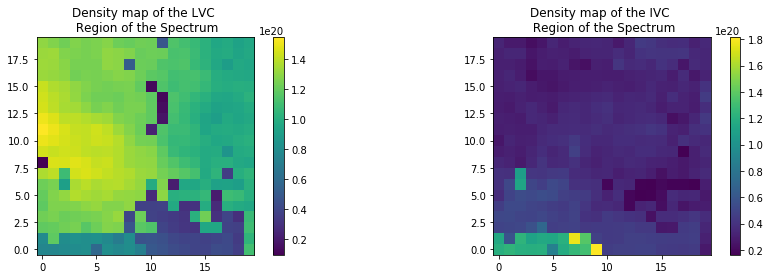

In [55]:
amplitudes_map = params[0::3]
velocities_map = params[1::3]
dispersions_map = params[2::3]

NHI_map = np.sqrt(2*np.pi)*amplitudes_map*dispersions_map*dv*C

print("Here are the Integrated Column density maps of each Gaussian\n")

plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.title("Density map of the LVC \n Region of the Spectrum")
plt.imshow(NHI_map[0],origin="lower")
plt.colorbar()
plt.subplot(1,2,2)
plt.title("Density map of the IVC \n Region of the Spectrum")
plt.imshow(NHI_map[1],origin="lower")
plt.colorbar()
#plt.subplot(1,3,3)
#plt.title("Density map of the HVC \n Region of the Spectrum")
#plt.imshow(NHI_map[2], origin="lower")
#plt.colorbar()

From these column Density maps, we can see that the density over to the 20 x 20 face is fairly homogeneous. There are definitely spots that show fluctuations in the density, but overall, the values are consistent. These errors can come from the fact that this model is plotting only one gaussain per peak. So for the LVC and IVC peaks, they are being modeled by a single gaussian. If I used more the one gaussian, this would help to eliminate these spots. 

#### Calculating the Residual of the Average Spectrum

The standard deviation of the residual is: 0.06670792468086485


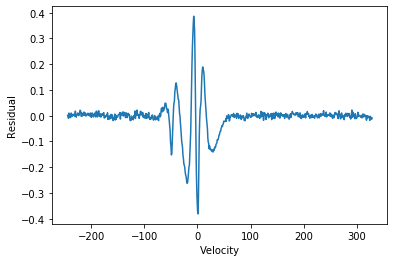

In [49]:
# Residual Spectrum (data-model)
model_spec_avg = gauss_comb_avg
data_spec_avg = avg_subcube
residual_spec_avg = model_spec_avg - data_spec_avg

print("The standard deviation of the residual is:", np.std(residual_spec_avg))

plt.plot(vel,residual_spec_avg)
plt.xlabel('Velocity')
plt.ylabel('Residual')
plt.show()

From this we can see that the model fits the data very well. The standard deviation of the residual is only 0.07 compared to the 0.13 of the single spectrum. At the main peak, the gaussian does not quite reach the height of the spectrum,so that is why the residual close to zero is relatively high. Same goes for the second highest peak.